In [12]:
import json
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import numpy as np
import pyperclip
from scipy.optimize import curve_fit

In [3]:
"""
example usage:
python run_iterative_experiment.py --experiment_name test_runs --experiment_type dfl --domain re2 --encoder re2 --iterations 3 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 64 --enumeration_timeout 600 --recognition_train_steps 0  --type_suffix _600 --type_override tstr
"""

'\nexample usage:\npython run_iterative_experiment.py --experiment_name test_runs --experiment_type dfl --domain re2 --encoder re2 --iterations 3 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 64 --enumeration_timeout 600 --recognition_train_steps 0  --type_suffix _600 --type_override tstr\n'

# Define loading / plotting functions

In [13]:
DSL, PYTHON, DSL_INDUCED, PYTHON_INDUCED = "DSL", "Python", "DSL (translated)", "Python (induced)"

In [14]:
def load_exp_results(exp_name, models, domain, seeds=(111,), batch_size="all", split="train"):
    """Loads the experiment results."""

    python_solved_rel_path = os.path.join("train", "gpt_solver_python_results.json")
    converted_rel_path = os.path.join("train", "gpt_converter_python2dsl_results.json")

    max_iters = 20
    base_path = os.path.join("../experiments_iterative/outputs/", exp_name)
    results = {model: {} for model in models}
    tasks_solved = {model: {} for model in models}
    for model in models:
        for seed in seeds:
            model_path = os.path.join(base_path, "domains", domain, model, f"seed_{seed}", f"{model}_{batch_size}")
            if not os.path.exists(model_path):
                continue

            for j in range(max_iters):

                # DSL frontiers.
                frontiers_path = os.path.join(model_path, str(j), "frontiers.json")
                if os.path.exists(frontiers_path):
                    with open(frontiers_path, "r") as f:
                        frontiers_res = json.load(f)
                        results[model].setdefault(seed, {}).setdefault(DSL, []).append(frontiers_res["_summary"]["n_tasks_solved"][split])
                        tasks_solved[model].setdefault(seed, {}).setdefault(DSL, []).append([
                            task_id for task_id, task_info in frontiers_res["train"].items() if task_info["programs"]
                        ])

                # Python frontiers.
                python_frontiers_path = os.path.join(model_path, str(j), "python_frontiers.json")
                if os.path.exists(python_frontiers_path):
                    with open(python_frontiers_path, "r") as f:
                        python_frontiers_res = json.load(f)
                        results[model].setdefault(seed, {}).setdefault(PYTHON, []).append(python_frontiers_res["_summary"]["n_tasks_solved"][split])
                        tasks_solved[model].setdefault(seed, {}).setdefault(PYTHON, []).append([
                            task_id for task_id, task_info in python_frontiers_res["train"].items() if task_info["programs"]
                        ])

                # Python (induced by LLM).
                python_solved_path = os.path.join(model_path, str(j), python_solved_rel_path)
                if os.path.exists(python_solved_path):
                    with open(python_solved_path, "r") as f:
                        # (Make cumulative.)
                        v = json.load(f)
                        if len(results[model].get(PYTHON_INDUCED, [])) == 0:
                            results[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["n_tasks_solved"])
                        else:
                            results[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["n_tasks_solved"] + results[model][PYTHON_INDUCED][-1])
                        
                        tasks_solved[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["tasks_solved"])

                # DSL (translated from python).
                converted_path = os.path.join(model_path, str(j), converted_rel_path)
                if os.path.exists(converted_path):
                    with open(converted_path, "r") as f:
                        results[model].setdefault(seed, {}).setdefault(DSL_INDUCED, []).append(json.load(f)["summary"]["n_tasks_solved"])

    return results, tasks_solved

In [15]:
def variable_length_mean(arrays):
    # Determine the maximum length of the arrays
    max_length = max(len(arr) for arr in arrays)

    # Initialize lists to accumulate the values
    column_sums = [0] * max_length
    column_counts = [0] * max_length

    # Accumulate sums and counts
    for arr in arrays:
        for i in range(len(arr)):
            column_sums[i] += arr[i]
            column_counts[i] += 1

    # Calculate the mean for each column
    column_means = [column_sums[i] / column_counts[i] for i in range(max_length)]

    return column_means

def variable_length_std(arrays):
    # Calculate means first
    max_length = max(len(arr) for arr in arrays)
    column_sums = [0] * max_length
    column_counts = [0] * max_length

    for arr in arrays:
        for i in range(len(arr)):
            column_sums[i] += arr[i]
            column_counts[i] += 1

    means = [column_sums[i] / column_counts[i] for i in range(max_length)]

    # Calculate standard deviation
    column_variances = [0] * max_length
    for arr in arrays:
        for i in range(len(arr)):
            column_variances[i] += (arr[i] - means[i]) ** 2

    column_stds = [(column_variances[i] / column_counts[i]) ** 0.5 for i in range(max_length)]

    return column_stds

def plot(results, domain, types_to_plot=(DSL, PYTHON, DSL_INDUCED, PYTHON_INDUCED), ax=None):
    """Plot the results of an experiment."""

    if ax is None:
        fig, ax = plt.subplots()

    type_to_linestyle = {
        DSL: "-", PYTHON: "-.", DSL_INDUCED: "--", PYTHON_INDUCED: ":"
    }
    colors = ["g", "b", "r", "y", "m", "c", "k"]
    model_to_color = {}

    n_iters = 0
    for i, (model, seed_res) in enumerate(results.items()):
        # model = model.split("_")[0]
        if model not in model_to_color:
            model_to_color[model] = colors[i % len(colors)]
        plotted = False
        for model_type in types_to_plot:
            tasks_solved_across_seeds = []
            for seed, tasks_solved in seed_res.items():
                if model_type not in tasks_solved:
                    continue
                n_iters = max(n_iters, len(tasks_solved[model_type]))
                tasks_solved_across_seeds.append(tasks_solved[model_type])
            if not tasks_solved_across_seeds:
                continue
            max_len = max(len(tasks_solved) for tasks_solved in tasks_solved_across_seeds)

            plotted = True
            if max_len == 1:
                # Make a dot if only one val
                ax.plot(variable_length_mean(tasks_solved_across_seeds), linestyle=type_to_linestyle[model_type], color=model_to_color[model], marker="o")
            else:
                ax.plot(variable_length_mean(tasks_solved_across_seeds), linestyle=type_to_linestyle[model_type], color=model_to_color[model])
            std = variable_length_std(tasks_solved_across_seeds)
            ax.fill_between(range(n_iters), np.array(variable_length_mean(tasks_solved_across_seeds)) - np.array(std), np.array(variable_length_mean(tasks_solved_across_seeds)) + np.array(std), alpha=0.1, color=model_to_color[model])

        if plotted:
            ax.plot([], [], color=model_to_color[model], label=model)

    # Add legend for types.
    ax.plot([], [], color="white", label=" ")
    for model_type in types_to_plot:
        ax.plot([], [], linestyle=type_to_linestyle[model_type], color="gray", label=model_type)

    ax.set_title(f"Tasks solved during training ({domain})")
    ax.set_xticks(range(n_iters))
    ax.set_xticklabels([str(i+1) for i in range(n_iters)])
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Tasks solved")
    ax.legend()

In [16]:
def plot_venn(tasks_solved):
    """Plot the Venn diagram of tasks solved."""
    assert len(tasks_solved) in (2, 3)
    assert all(isinstance(v, (list, set)) for v in tasks_solved.values())

    model_names = list(tasks_solved.keys())
    if len(tasks_solved) == 2:
        venn2([set(tasks_solved[model_names[0]]), set(tasks_solved[model_names[1]])], set_labels=model_names)
    else:
        venn3([set(tasks_solved[model_names[0]]), set(tasks_solved[model_names[1]]), set(tasks_solved[model_names[2]])],
                  set_labels=model_names)

In [124]:
# Random utilities.

def is_power_of_two(n):
    return n & (n - 1) == 0

def pow2_factors(n):
    return [2 ** i for i in range(int(np.log2(n)) + 1)]

def make_n_random_seeds(n):
    return list(range(n))

# Misc

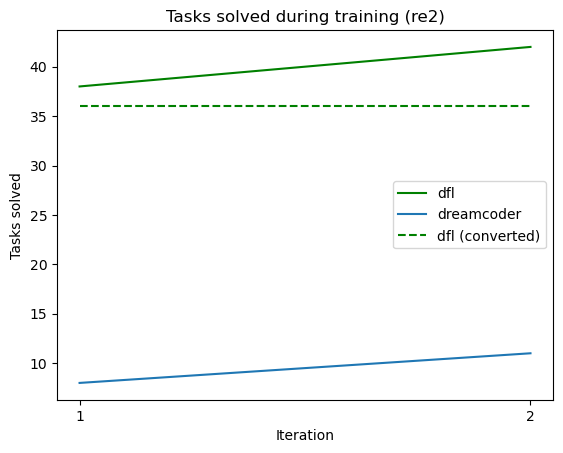

In [181]:
# Shows even small search budget w/ neural recognitin model can solve tasks.

exp_name = "enum120_rts10000_tasks100"
models = ["dfl", "dreamcoder"]
re2_res = load_exp_results(exp_name, models, domain="re2")
plot(re2_res, "re2")

In [194]:
exp_name = "enum_120_nolanguage"
models = ["llm_str", "dreamcoder", "dfl_str"]
list_res, list_solve = load_exp_results(exp_name, models, domain="list_functions")

In [195]:
n_iters = 3

list_solved_all = {}
for model in list_solve:
    for method in list_solve[model]:
        all_solved = set([task for tasks in list_solve[model][method][:n_iters] for task in tasks])
        list_solved_all.setdefault(model, set()).update(all_solved)

list_solved_python = {}
for model in list_solve:
    if PYTHON not in list_solve[model]:
        continue
    all_solved = set([task for tasks in list_solve[model][PYTHON][:n_iters] for task in tasks])
    list_solved_python[model] = all_solved

list_solved_python_induced = {}
for model in list_solve:
    if PYTHON_INDUCED not in list_solve[model]:
        continue
    all_solved = set([task for tasks in list_solve[model][PYTHON_INDUCED][:n_iters] for task in tasks])
    list_solved_python_induced[model] = all_solved

/opt/miniconda3/envs/dfl2dsl/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


Text(0.5, 1.0, 'Python (induced) tasks solved')

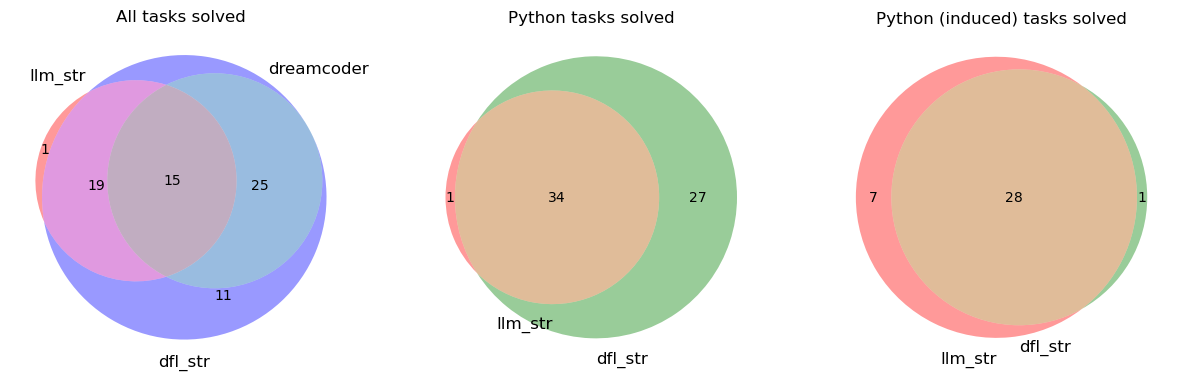

In [196]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(131)
plot_venn(list_solved_all)
plt.title("All tasks solved")
fig.add_subplot(132)
plot_venn(list_solved_python)
plt.title("Python tasks solved")
fig.add_subplot(133)
plot_venn(list_solved_python_induced)
plt.title("Python (induced) tasks solved")

# Fit power law to number of samples to solve

## Loading / plotting functions

In [118]:
def make_powerlaw_exps(domain, tot_samples: int = 32, n_tasks: int = 100, exp_name = "llm_baselines", min_samples: int = 1, max_samples: int = 64):
    """Make commands for powerlaw experiments."""

    # TODO: Add argument for max # experiments to run. If tot_samples = 64, then we are running 64 experiments with
    # n=1 which is excessive.

    # Assert tot_samples is a power of 2.
    assert is_power_of_two(tot_samples)

    # Make the commands.
    commands = []
    model_names = []
    for n in pow2_factors(tot_samples):
        if n < min_samples or n > max_samples:
            continue
        commands.append(
            f"python run_iterative_experiment.py --experiment_name {exp_name} --experiment_type llm "
            f"--domain {domain} --iterations 1 --global_batch_size_all --random_seeds {' '.join(str(s) for s in make_n_random_seeds(tot_samples // n))} "
            f"--n_test 0 --n_train {n_tasks} --verbose --no_lang --type_suffix gpt3.5-t=0.7-n={n}-t2p --n_samples_python {n}")
        model_names.append(f"llmgpt3.5-t=0.7-n={n}-t2p")
        if domain == "re2":
            commands[-1] += " --type_override tstr"
    
    return commands, model_names

In [119]:
def load_enum_results(exp_name, models, domain, seeds=(0,), batch_size="all"):
    """Loads the enumeration results from an experiment (the time to find solutions)."""

    max_iters = 20
    base_path = os.path.join("../experiments_iterative/outputs/", exp_name)
    results = {model: {} for model in models}
    for model in models:
        for seed in seeds:
            model_path = os.path.join(base_path, "domains", domain, model, f"seed_{seed}", f"{model}_{batch_size}")
            if not os.path.exists(model_path):
                continue

            # DSL frontiers.
            for j in range(max_iters):
                frontiers_path = os.path.join(model_path, str(j), "frontiers.json")
                if os.path.exists(frontiers_path):
                    with open(frontiers_path, "r") as f:
                        frontiers_res = json.load(f)
                    ts = frontiers_res["train"]
                    solve_times = [task_info["best_search_time"] for task_info in ts.values() if task_info["best_search_time"]]
                    results[model].setdefault(seed, []).append(solve_times)

    return results

In [120]:
def power_law(x, a, b):
    """Defines a power law parameterized by a and b."""
    return a * x ** b
def fit_power_law(x, y):
    """Fit a power law to the data, with error bounds."""

    popt, pcov = curve_fit(power_law, x, y)
    perr = np.sqrt(np.diag(pcov))
    return popt, perr
def calc_x_needed_for_y_power_law(power_law_params, y):
    """Calculate the x value needed to reach y using power law model, with error bounds."""
    a, b = power_law_params
    x = (y / a) ** (1 / b)
    x_err = (y / a) ** (1 / b) * np.sqrt((b * y) / (a * a))
    return x, x_err

def cum_log_norm(x, a, b, h, k):
    """Cumulative log-normal distribution."""
    return a*np.log10(b*x + h) + k
def fit_cum_log_normal(x, y, guess=None):
    """Fit a cumulative log-normal distribution to the data."""
    popt, pcov = curve_fit(cum_log_norm, x, y, p0=guess)
    perr = np.sqrt(np.diag(pcov))
    return popt, perr
def calc_x_needed_for_y_cum_log_normal(cum_log_normal_params, y):
    """Calculate the x value needed to reach y using cum log model, with error bounds."""
    a, b, h, k = cum_log_normal_params
    x = (10 ** ((y - k) / a) - h) / b
    x_err = (10 ** ((y - k) / a) - h) / b * np.sqrt((b * y) / (a * a))
    return x, x_err

## LLM Sampling scaling laws

Not sure what model to fit to the data. I think cumulative log normal because if we let $p(t)_{m}=$ probability of a single sample from the model $m$ solving the task $t$, then, for any given task, the probability of solving that task with $k$ samples is $k p(t)_m$. If we also assume each task $t$ is IID, then the cumulative number of tasks solved is the sum of the product of many IID variables (which leads to a log normal distribution afaik)

In [121]:
# Define constants for experiment to run / analyze.
exp_name = "llm_baselines"
n_tasks = 100
t = 0.7
model = "gpt-3.5"
assert t == 0.7 and model == "gpt-3.5" and n_tasks == 100   # TODO: Make CLA

domains = ["list_functions", "re2", "clevr"]
tot_samples = 64

# For exp to run...
min_samples, max_samples = 1, 64

In [125]:
# Make commands for experiments to run.
# (Run these experiments before continuing...)
commands = []
models = set()
for domain in domains:
    cmds, model_names = make_powerlaw_exps(domain, tot_samples=tot_samples, n_tasks=n_tasks, min_samples=min_samples, max_samples=max_samples)
    commands.extend(cmds)
    models.update(set(model_names))

str_commands = "; \\\n".join(commands)
pyperclip.copy(str_commands)

In [126]:
# Parse results from run experiments.
results, solve_results = {}, {}
for domain in domains:
    results[domain], solve_results[domain] = load_exp_results(exp_name, models, domain=domain, seeds=make_n_random_seeds(tot_samples))


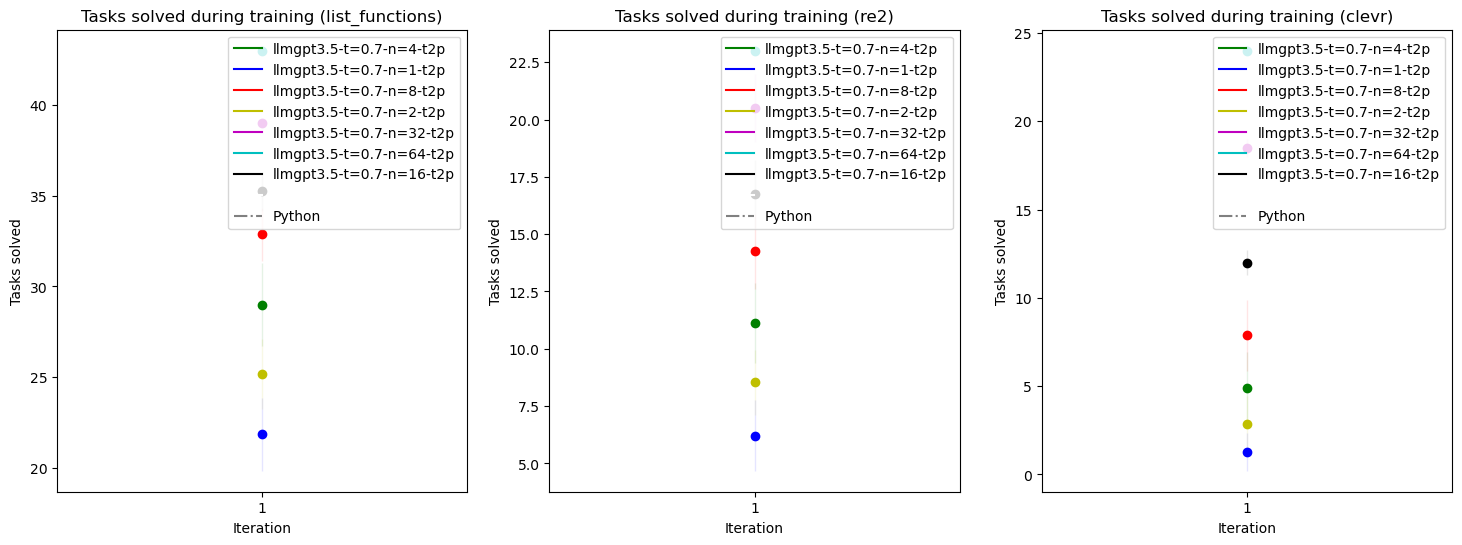

In [127]:
# Plot tasks solved v. # samples.
fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
for ax, domain in zip(axes, domains):
    plot(results[domain], domain, types_to_plot=(PYTHON,), ax=ax)

/opt/miniconda3/envs/dfl2dsl/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


list_functions
	# samples to solve 72 tasks: 23376.54 +/- 102640.4
	# samples to solve 55 tasks: 761.96 +/- 2924.1
re2
	# samples to solve 72 tasks: 3492732.77 +/- 12279605.6
	# samples to solve 55 tasks: 78492.74 +/- 241192.4
clevr
	# samples to solve 72 tasks: 6816.28 +/- 2336.4
	# samples to solve 55 tasks: 1338.83 +/- 401.1


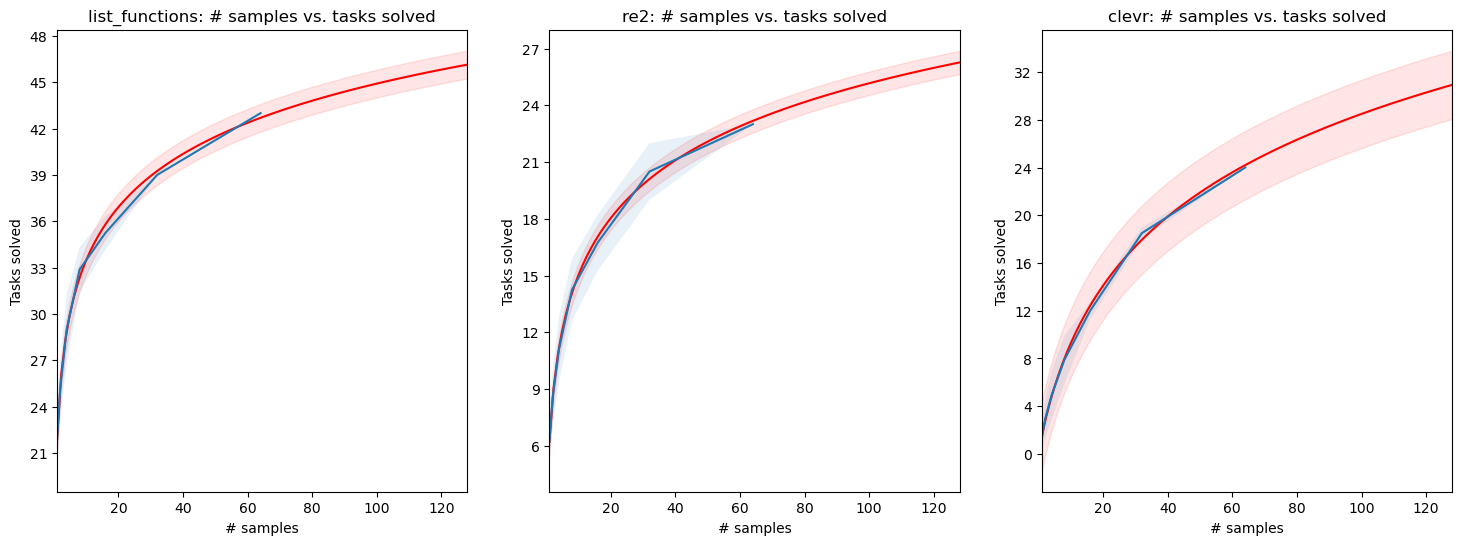

In [128]:
# Calculate + plot power law for # samples.

LOG_NORMAL, POWER_LAW = "log_normal", "power_law"
scaling_model = LOG_NORMAL
model2fit = {LOG_NORMAL: fit_cum_log_normal, POWER_LAW: fit_power_law}
model2pred = {LOG_NORMAL: cum_log_norm, POWER_LAW: power_law}
model2calc = {LOG_NORMAL: calc_x_needed_for_y_cum_log_normal, POWER_LAW: calc_x_needed_for_y_power_law}

fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
min_x, max_x = 1, 64*2
plot_xs = np.linspace(min_x, max_x, 100)

for domain, ax in zip(domains, axes):
    res = results[domain]
    n_to_solved = {}
    n_to_solved_std = {}
    xs, ys = [], []
    for n in pow2_factors(tot_samples):
        if n < min_samples or n > max_samples:
            continue
        name = f"llmgpt3.5-t=0.7-n={n}-t2p"
        n_solved = [res[name][seed][PYTHON][0] for seed in res[name]]
        if n_solved:
            n_to_solved[n] = np.mean(n_solved)
            n_to_solved_std[n] = np.std(n_solved)
            xs += [n for _ in n_solved]
            ys += n_solved

    # Fit a power law to the data.
    ns_ = sorted(n_to_solved.keys())
    # popt, perr = model2fit[scaling_model](xs, ys)
    popt, perr = model2fit[scaling_model](list(n_to_solved.keys()), list(n_to_solved.values()))

    # Plot model preds + error bars.
    f = model2pred[scaling_model]
    ax.plot(plot_xs, [f(x, *popt) for x in plot_xs], color="r")
    ax.fill_between(plot_xs, [f(x, *popt) - perr[0] for x in plot_xs], [f(x, *popt) + perr[0] for x in plot_xs], alpha=0.1, color="r")

    # Plot experiment data + error bars.
    ax.plot(ns_, [n_to_solved[n] for n in ns_])
    ax.fill_between(ns_, [n_to_solved[n] - n_to_solved_std[n] for n in ns_], [n_to_solved[n] + n_to_solved_std[n] for n in ns_], alpha=0.1)

    ax.set_xlim(min_x, max_x)
    ax.set_title(f"{domain}: # samples vs. tasks solved")
    ax.set_xlabel("# samples")
    ax.set_ylabel("Tasks solved")
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # # make both axes logarithmic
    # ax.set_xscale('log')
    # ax.set_yscale('log')

    # Calculate # samples needed to solve 25, 50, 75, 100 tasks.
    print(domain)
    for n_tasks in [72, 55]:
        x, x_err = model2calc[scaling_model](popt, n_tasks)
        print(f"\t# samples to solve {n_tasks} tasks: {x:.2f} +/- {x_err:.1f}")

## Enumeration scaling laws

Fitting a low-dimensional distribution to # tasks solved v. enumeration time is tricky. I don't attempt it here, just plot experimental results.

In [56]:
# Parse results from run experiments.
enum_exp_name = "enumeration_baselines"
max_enum_time = 300
domains = ["clevr", "re2", "list_functions"]
models = ["enumeration"]
enum_results = {}
for domain in domains:
    enum_results[domain] = load_enum_results(enum_exp_name, models, domain=domain, seeds=(111,))


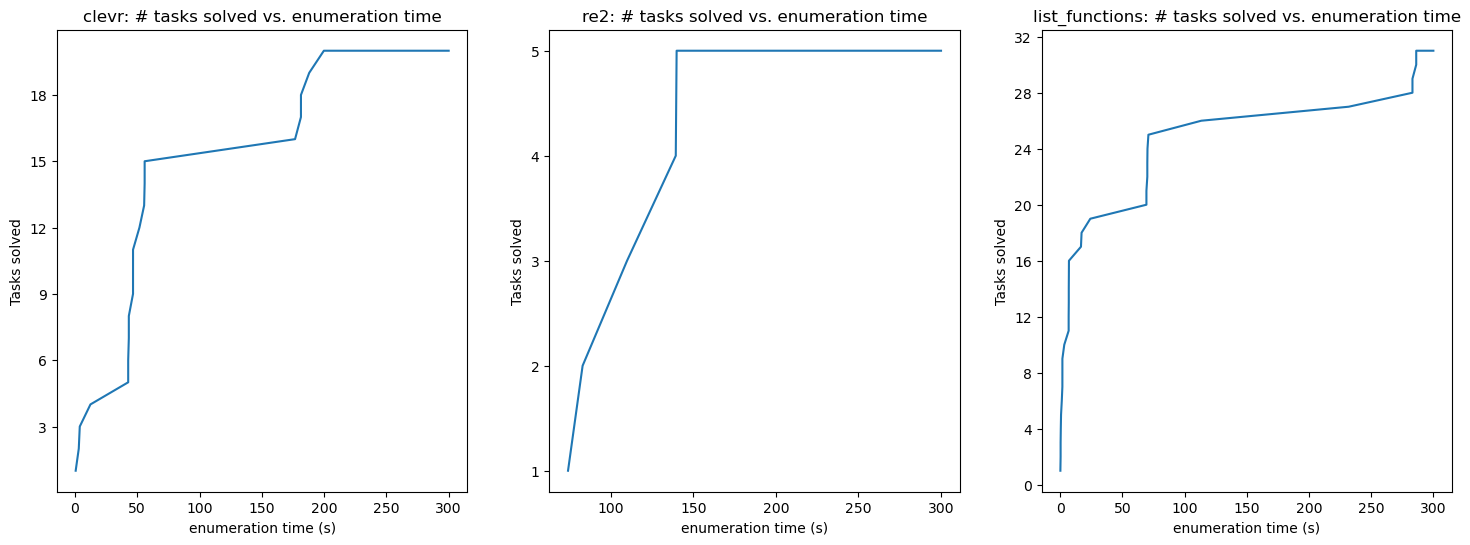

In [61]:
# Calculate + plot power law for # samples.

fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))

for domain, ax in zip(domains, axes if len(domains) > 1 else [axes]):

    res = enum_results[domain]
    model2res = {}
    xs, ys = [], []
    for model in models:
        model2res[model] = []
        solve_times = [res[model][seed] for seed in res[model]]
        if len(solve_times) > 1:
            print("Warning: Only plotting first seed.")
        solve_times = solve_times[0]
        for iter_solve_times in solve_times:
            if iter_solve_times:
                iter_solve_times.sort()
                xs = iter_solve_times + [max_enum_time]
                ys = list(range(1, len(iter_solve_times)+1)) + [len(iter_solve_times)]
                model2res[model].append((xs, ys))
            else:
                break

    # Plot experiment data + error bars.
    for model, res in model2res.items():
        for i, (xs, ys) in enumerate(res):
            ax.plot(xs, ys, label=f"{xs} ({i})")

    ax.set_title(f"{domain}: # tasks solved vs. enumeration time")
    ax.set_xlabel("enumeration time (s)")
    ax.set_ylabel("Tasks solved")
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

## DFL Scaling Laws

Analyses to show that our method scales better w/ more compute in terms of solving more problems

In [18]:
# Parse results from run experiments.

max_enum_times = [120, 300, 600]
domains = ["clevr", "re2", "list_functions"]
models = ["dfl_120", "dfl_300", "dfl_600"]
dfl_exp_name = "dfl_baselines"
dfl_enum_results = {}
dfl_exp_results = {}
for domain in domains:
    dfl_enum_results[domain] = load_enum_results(dfl_exp_name, models, domain=domain, seeds=(0,))
    dfl_exp_results[domain], _ = load_exp_results(dfl_exp_name, models, domain=domain, seeds=(0,))


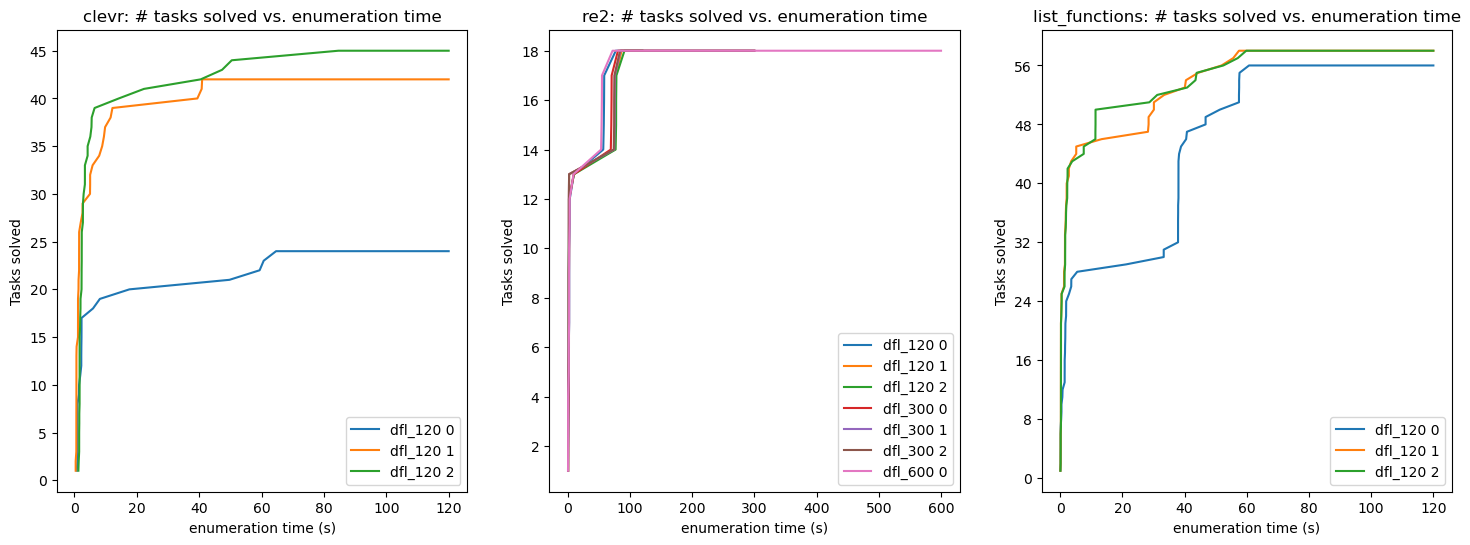

In [19]:
# Calculate + plot power law for enumeration time at different iterations.

fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))

for domain, ax in zip(domains, axes if len(domains) > 1 else [axes]):

    res = dfl_enum_results[domain]
    model2res = {}
    xs, ys = [], []
    for model, max_enum_time in zip(models, max_enum_times):
        model2res[model] = []
        solve_times = [res[model][seed] for seed in res[model]]
        if len(solve_times) > 1:
            print("Warning: Only plotting first seed.")
        if not solve_times:
            continue
        solve_times = solve_times[0]
        for iter_solve_times in solve_times:
            if iter_solve_times:
                iter_solve_times.sort()
                xs = iter_solve_times + [max_enum_time]
                ys = list(range(1, len(iter_solve_times)+1)) + [len(iter_solve_times)]
                model2res[model].append((xs, ys))
            else:
                break

    # Plot experiment data + error bars.
    for model, res in model2res.items():
        for i, (xs, ys) in enumerate(res):
            ax.plot(xs, ys, label=f"{model} {i}")

    ax.set_title(f"{domain}: # tasks solved vs. enumeration time")
    ax.set_xlabel("enumeration time (s)")
    ax.set_ylabel("Tasks solved")
    ax.legend()
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

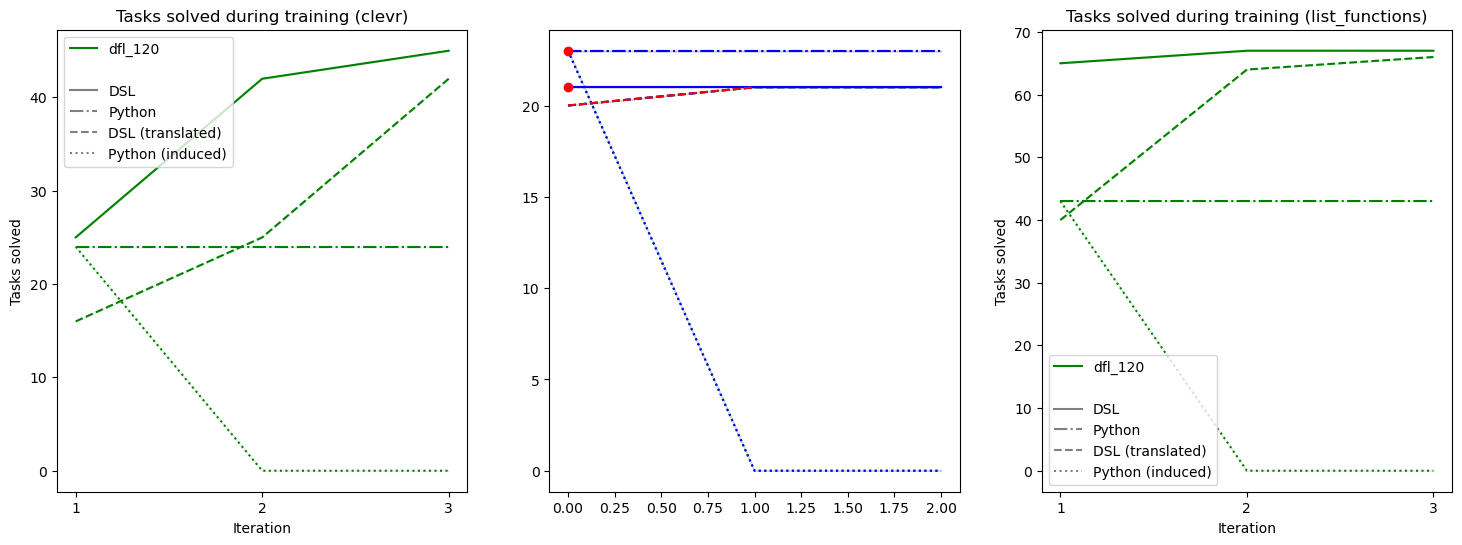

In [20]:
fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
axes = [axes] if len(domains) == 1 else axes

for domain, ax in zip(domains, axes):
    try:
        plot(dfl_exp_results[domain], domain, ax=ax)
    except:
        pass

# Misc scripts

## Conversion of logs for Will

Extract python from logs to make (python, lambda calculus function) pairs

In [16]:

log_path = "/Users/samacquaviva/Documents/projects/dfl2dsl/experiments_iterative/outputs/dfl_baselines/domains/list_functions/dfl/seed_0/dfl_all/2/train/gpt_converter_python2dsl_results.json"
with open(log_path, "r") as f:
    log = json.load(f)


In [32]:
task_to_python = {}
for task_id, chat_log in log["logs_per_task"].items():
    chat_log = chat_log[0]
    # if not chat_log.get("search_prog", None) or chat_log.get("llm_prog", None):
    #     continue
    chat = chat_log["chat"]
    python_chat = chat[5]["content"]
    python_f = python_chat.split("```")[1]
    def_indented = python_f.index("def")
    python_f = python_f[def_indented:]

    task_to_python[task_id] = python_f

with open("a.json", "w") as f:
    json.dump({**log, **{"task_to_python": task_to_python}}, f)

In [30]:
def load_exp_results(exp_name, models, domain, seeds=(111,), batch_size="all", split="train"):
    """Loads the experiment results."""

    python_solved_rel_path = os.path.join("train", "gpt_solver_python_results.json")
    converted_rel_path = os.path.join("train", "gpt_converter_python2dsl_results.json")

    max_iters = 20
    base_path = os.path.join("../experiments_iterative/outputs/", exp_name)
    results = {model: {} for model in models}
    tasks_solved = {model: {} for model in models}
    for model in models:
        for seed in seeds:
            model_path = os.path.join(base_path, "domains", domain, model, f"seed_{seed}", f"{model}_{batch_size}")
            if not os.path.exists(model_path):
                print(f"Missing: {model_path}")
                continue

            for j in range(max_iters):

                # DSL frontiers.
                frontiers_path = os.path.join(model_path, str(j), "frontiers.json")
                if os.path.exists(frontiers_path):
                    with open(frontiers_path, "r") as f:
                        frontiers_res = json.load(f)
                        results[model].setdefault(seed, {}).setdefault(DSL, []).append(frontiers_res["_summary"]["n_tasks_solved"][split])
                        tasks_solved[model].setdefault(seed, {}).setdefault(DSL, []).append([
                            task_id for task_id, task_info in frontiers_res["train"].items() if task_info["programs"]
                        ])

                # Python frontiers.
                python_frontiers_path = os.path.join(model_path, str(j), "python_frontiers.json")
                if os.path.exists(python_frontiers_path):
                    with open(python_frontiers_path, "r") as f:
                        python_frontiers_res = json.load(f)
                        results[model].setdefault(seed, {}).setdefault(PYTHON, []).append(python_frontiers_res["_summary"]["n_tasks_solved"][split])
                        tasks_solved[model].setdefault(seed, {}).setdefault(PYTHON, []).append([
                            task_id for task_id, task_info in python_frontiers_res["train"].items() if task_info["programs"]
                        ])

                # Python (induced by LLM).
                python_solved_path = os.path.join(model_path, str(j), python_solved_rel_path)
                if os.path.exists(python_solved_path):
                    with open(python_solved_path, "r") as f:
                        # (Make cumulative.)
                        v = json.load(f)
                        if len(results[model].get(PYTHON_INDUCED, [])) == 0:
                            results[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["n_tasks_solved"])
                        else:
                            results[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["n_tasks_solved"] + results[model][PYTHON_INDUCED][-1])
                        
                        tasks_solved[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["tasks_solved"])

                # DSL (translated from python).
                converted_path = os.path.join(model_path, str(j), converted_rel_path)
                if os.path.exists(converted_path):
                    with open(converted_path, "r") as f:
                        results[model].setdefault(seed, {}).setdefault(DSL_INDUCED, []).append(json.load(f)["summary"]["n_tasks_solved"])

    return results, tasks_solved

In [34]:
# Parse results from run experiments.

domains = ["clevr", "re2", "list_functions"]
models = ["dreamcoder", "dfl"]
exp_name = "enum120_rts0_tasks100"
exp_results = {}
for domain in domains:
    exp_results[domain], _ = load_exp_results(exp_name, models, domain=domain, seeds=(111,))

exp_results

{'clevr': {'dreamcoder': {111: {'DSL': [15, 28, 42, 47, 44, 48, 50]}},
  'dfl': {111: {'DSL': [55, 75, 77, 78],
    'Python': [34, 34, 34, 34],
    'Python (induced)': [34, 34, 34, 34]}}},
 're2': {'dreamcoder': {111: {'DSL': [5, 5, 5]}},
  'dfl': {111: {'DSL': [36, 39, 36],
    'Python': [49, 49, 49],
    'Python (induced)': [49, 49, 49]}}},
 'list_functions': {'dreamcoder': {111: {'DSL': [56, 68, 69]}},
  'dfl': {111: {'DSL': [84, 99, 99],
    'Python': [72, 72, 72],
    'Python (induced)': [72, 72, 72]}}}}

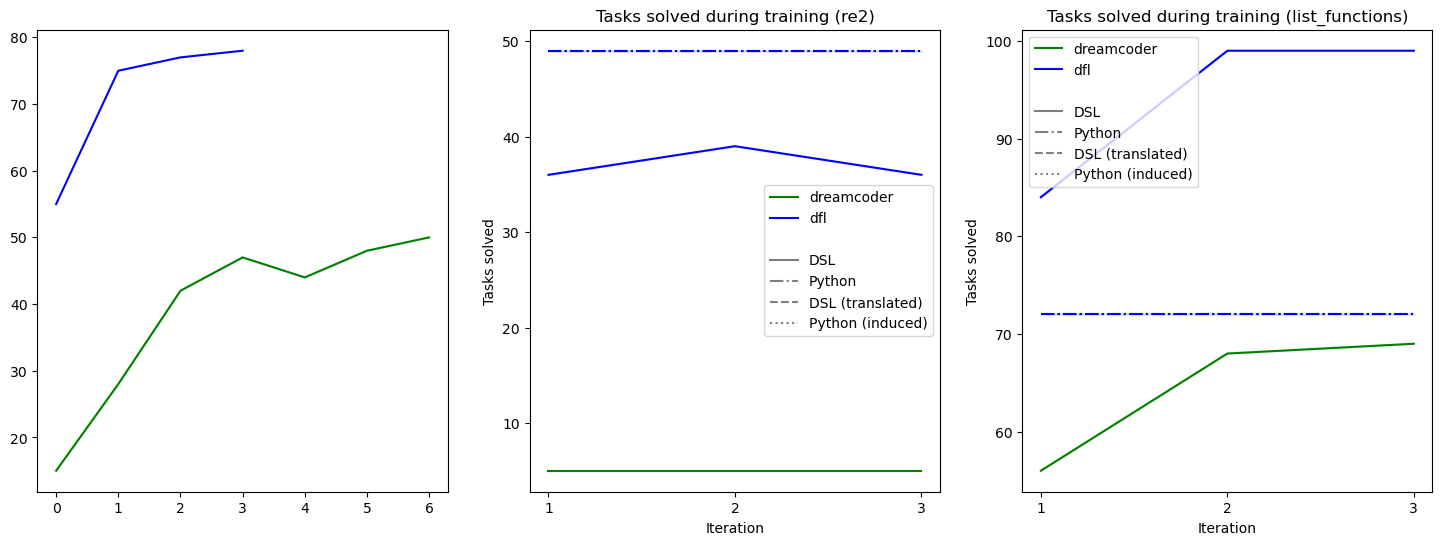

In [35]:
fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
axes = [axes] if len(domains) == 1 else axes

for domain, ax in zip(domains, axes):
    try:
        plot(exp_results[domain], domain, ax=ax)
    except:
        pass

In [ ]:
def plot_major_fig(results, domain, ax=None, xlabel="Iteration"):
    """Plot the results of an experiment."""

    if ax is None:
        fig, ax = plt.subplots()

    n_iters = 0
    for i, (model, model_res) in enumerate(results.items()):

        xs, ys = zip(*model_res.items())
        ax.plot(xs, ys, label=model)

    ax.set_title(f"Tasks solved during training ({domain})")
    ax.set_xticks(range(n_iters))
    ax.set_xticklabels([str(i+1) for i in range(n_iters)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("% tasks solved")
    ax.legend()

In [ ]:
def load_exp_results(exp_name, models, domain, seeds=(111,), batch_size="all", split="train"):
    """Loads the experiment results."""

    python_solved_rel_path = os.path.join("train", "gpt_solver_python_results.json")
    converted_rel_path = os.path.join("train", "gpt_converter_python2dsl_results.json")

    max_iters = 20
    base_path = os.path.join("../experiments_iterative/outputs/", exp_name)
    results = {model: {} for model in models}
    tasks_solved = {model: {} for model in models}
    for model in models:
        for seed in seeds:
            model_path = os.path.join(base_path, "domains", domain, model, f"seed_{seed}", f"{model}_{batch_size}")
            if not os.path.exists(model_path):
                continue

            for j in range(max_iters):

                # DSL frontiers.
                frontiers_path = os.path.join(model_path, str(j), "frontiers.json")
                if os.path.exists(frontiers_path):
                    with open(frontiers_path, "r") as f:
                        frontiers_res = json.load(f)
                        results[model].setdefault(seed, {}).setdefault(DSL, []).append(frontiers_res["_summary"]["n_tasks_solved"][split])
                        tasks_solved[model].setdefault(seed, {}).setdefault(DSL, []).append([
                            task_id for task_id, task_info in frontiers_res["train"].items() if task_info["programs"]
                        ])

                # Python frontiers.
                python_frontiers_path = os.path.join(model_path, str(j), "python_frontiers.json")
                if os.path.exists(python_frontiers_path):
                    with open(python_frontiers_path, "r") as f:
                        python_frontiers_res = json.load(f)
                        results[model].setdefault(seed, {}).setdefault(PYTHON, []).append(python_frontiers_res["_summary"]["n_tasks_solved"][split])
                        tasks_solved[model].setdefault(seed, {}).setdefault(PYTHON, []).append([
                            task_id for task_id, task_info in python_frontiers_res["train"].items() if task_info["programs"]
                        ])

                # Python (induced by LLM).
                python_solved_path = os.path.join(model_path, str(j), python_solved_rel_path)
                if os.path.exists(python_solved_path):
                    with open(python_solved_path, "r") as f:
                        # (Make cumulative.)
                        v = json.load(f)
                        if len(results[model].get(PYTHON_INDUCED, [])) == 0:
                            results[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["n_tasks_solved"])
                        else:
                            results[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["n_tasks_solved"] + results[model][PYTHON_INDUCED][-1])
                        
                        tasks_solved[model].setdefault(seed, {}).setdefault(PYTHON_INDUCED, []).append(v["summary"]["tasks_solved"])

                # DSL (translated from python).
                converted_path = os.path.join(model_path, str(j), converted_rel_path)
                if os.path.exists(converted_path):
                    with open(converted_path, "r") as f:
                        results[model].setdefault(seed, {}).setdefault(DSL_INDUCED, []).append(json.load(f)["summary"]["n_tasks_solved"])

    return results, tasks_solved

# Experiments

## List Functions

## CLEVR

### DFL
python run_iterative_experiment.py --experiment_name 65150_draft --experiment_type dfl --domain clevr --encoder clevr --iterations 2 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 64 --enumeration_timeout 300 --recognition_train_steps 0  --type_suffix _enum=300_nsamples=64; \
python run_iterative_experiment.py --experiment_name 65150_draft --experiment_type dfl --domain clevr --encoder clevr --iterations 4 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 64 --enumeration_timeout 120 --recognition_train_steps 0  --type_suffix _enum=120_nsamples=64; \
python run_iterative_experiment.py --experiment_name 65150_draft --experiment_type dfl --domain clevr --encoder clevr --iterations 2 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 64 --enumeration_timeout 120 --recognition_train_steps 0  --type_suffix _enum=120_nsamples=32; \
python run_iterative_experiment.py --experiment_name 65150_draft --experiment_type dfl --domain clevr --encoder clevr --iterations 2 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 64 --enumeration_timeout 120 --recognition_train_steps 0  --type_suffix _enum=120_nsamples=8; \
python run_iterative_experiment.py --experiment_name 65150_draft --experiment_type dfl --domain clevr --encoder clevr --iterations 2 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 64 --enumeration_timeout 10 --recognition_train_steps 0  --type_suffix _enum=10_nsamples=64; \

### DreamCoder
python run_iterative_experiment.py --experiment_name 65150_draft --experiment_type dreamcoder --domain clevr --encoder clevr --iterations 2 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 32 --enumeration_timeout 300 --recognition_train_steps 0  --type_suffix _enum=300; \
python run_iterative_experiment.py --experiment_name 65150_draft --experiment_type dreamcoder --domain clevr --encoder clevr --iterations 4 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 32 --enumeration_timeout 120 --recognition_train_steps 0  --type_suffix _enum=120; \
python run_iterative_experiment.py --experiment_name 65150_draft --experiment_type dreamcoder --domain clevr --encoder clevr --iterations 2 --global_batch_size_all --random_seeds 0 --n_test 0 --n_train 100 --verbose --no_lang --n_samples_python 32 --enumeration_timeout 10 --recognition_train_steps 0  --type_suffix _enum=10

In [131]:
domains = ["list_functions", "clevr"]
enum_times = [10, 120, 300]
n_samples = [8, 32, 64]
models = []
for enum in enum_times:
    models.append(f"dreamcoder_enum={enum}")
    for n in n_samples:
        models.append(f"dfl_enum={enum}_nsamples={n}")
exp_name = "65150_draft"
exp_results, exp_solved = {}, {}
for domain in domains:
    exp_results[domain], exp_solved[domain] = load_exp_results(exp_name, models, domain=domain, seeds=(0,))

exp_solved["list_functions"].keys()

dict_keys(['dreamcoder_enum=10', 'dfl_enum=10_nsamples=8', 'dfl_enum=10_nsamples=32', 'dfl_enum=10_nsamples=64', 'dreamcoder_enum=120', 'dfl_enum=120_nsamples=8', 'dfl_enum=120_nsamples=32', 'dfl_enum=120_nsamples=64', 'dreamcoder_enum=300', 'dfl_enum=300_nsamples=8', 'dfl_enum=300_nsamples=32', 'dfl_enum=300_nsamples=64'])

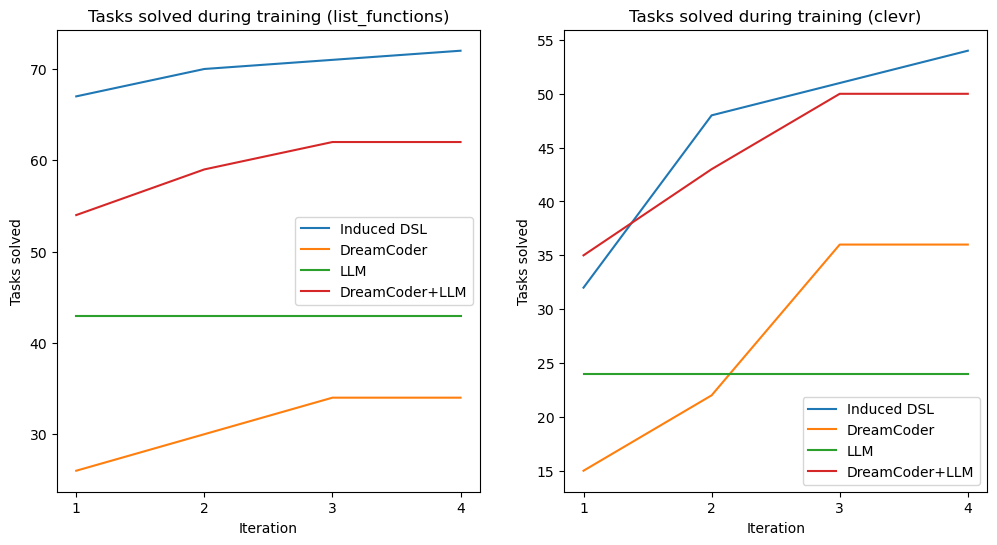

In [147]:
fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
axes = [axes] if len(domains) == 1 else axes
n_iters = 4
# Get # tasks solved by iteration.
# We want dfl_enum=120_nsamples=64 all
# dreamcoder_enum=120 all
# dfl_enum=120_nsamples=64 python first iteration
res = {"Induced DSL": [], "DreamCoder": [], "LLM": [], "DreamCoder+LLM": []}
for domain, domain_res in exp_solved.items():

    # Get n tasks solved by our method.
    dfl_n_tasks_solved = []
    llm_tasks_solved = []
    tasks_solved = domain_res["dfl_enum=120_nsamples=64"][0]
    for i in range(n_iters):
        iter_solved = set()
        for method, method_tasks_solved in tasks_solved.items():
            iter_solved.update(set(method_tasks_solved[i]))
            if i == 0 and method == PYTHON:
                llm_tasks_solved = method_tasks_solved[i]
        dfl_n_tasks_solved.append(len(iter_solved) + i)
    res["Induced DSL"].append(dfl_n_tasks_solved)

    # Get tasks solved by DreamCoder.
    dreamcoder_tasks_solved = []
    tasks_solved = domain_res["dreamcoder_enum=120"][0]
    for i in range(n_iters):
        iter_solved = set()
        for method, method_tasks_solved in tasks_solved.items():
            iter_solved.update(set(method_tasks_solved[i]) if i < len(method_tasks_solved) else set(method_tasks_solved[i-1]))
            if i > 0:
                iter_solved = set(list(iter_solved)[:-6])
        dreamcoder_tasks_solved.append(iter_solved)
    res["DreamCoder"].append([len(tasks) for tasks in dreamcoder_tasks_solved])

    # Get tasks solved by LLM.
    res["LLM"].append([len(llm_tasks_solved)] * n_iters)

    # Get union of tasks.
    res["DreamCoder+LLM"].append([len(set(dc_iter_tasks) | set(llm_tasks_solved)) for dc_iter_tasks in dreamcoder_tasks_solved])

for i, (domain, ax) in enumerate(zip(domains, axes)):
    ax.plot(res["Induced DSL"][i], label="Induced DSL")
    ax.plot(res["DreamCoder"][i], label="DreamCoder")
    ax.plot(res["LLM"][i], label="LLM")
    ax.plot(res["DreamCoder+LLM"][i], label="DreamCoder+LLM")

    ax.set_title(f"Tasks solved during training ({domain})")
    ax.set_xticks(range(n_iters))
    ax.set_xticklabels([str(i+1) for i in range(n_iters)])
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Tasks solved")
    ax.legend()

# save as pdf
# plt.save


{'Induced DSL': [{8: 59, 32: 70, 64: 74}, {8: 52, 32: 52, 64: 53}], 'DreamCoder': [{8: 36, 32: 36, 64: 36}, {8: 29, 32: 29, 64: 29}], 'LLM': [{8: 33, 32: 39, 64: 43}, {8: 24, 32: 24, 64: 25}], 'DreamCoder+LLM': [{8: 57, 32: 60, 64: 61}, {8: 47, 32: 47, 64: 48}]}


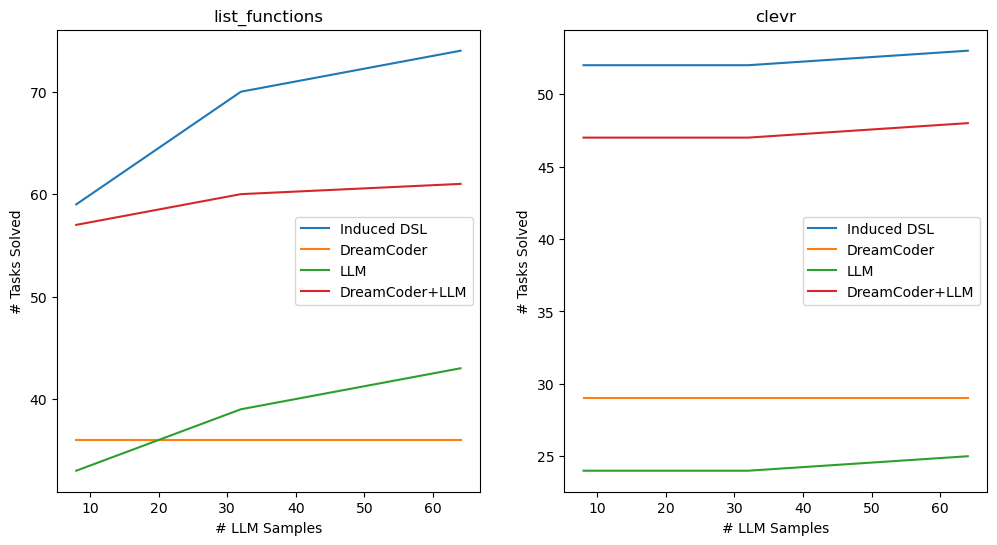

In [100]:
fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
axes = [axes] if len(domains) == 1 else axes
n_iters = 2

# Get # tasks solved by # samples.
# We want dfl_enum=120_nsamples=64 all
# dreamcoder_enum=120 all
# dfl_enum=120_nsamples=64 python first iteration
enum = 120
res = {"Induced DSL": [], "DreamCoder": [], "LLM": [], "DreamCoder+LLM": []}
for domain, domain_res in exp_solved.items():

    # Get n tasks solved by our method.
    dfl_n_tasks_solved = {}
    llm_tasks_solved = {}
    for n in n_samples:
        tasks_solved = domain_res[f"dfl_enum={enum}_nsamples={n}"][0]
        i = n_iters - 1     # Only want final iteration.
        iter_solved = set()
        for method, method_tasks_solved in tasks_solved.items():
            iter_solved.update(set(method_tasks_solved[i]))

        llm_tasks_solved[n] = tasks_solved[PYTHON][0]
        dfl_n_tasks_solved[n] = len(iter_solved)

    res["Induced DSL"].append(dfl_n_tasks_solved)

    # Get tasks solved by DreamCoder.
    tasks_solved = domain_res["dreamcoder_enum=120"][0]
    dreamcoder_tasks_solved = set()
    for method, method_tasks_solved in tasks_solved.items():
        dreamcoder_tasks_solved.update(set(method_tasks_solved[i]))

    res["DreamCoder"].append({n: len(dreamcoder_tasks_solved) for n in n_samples})

    # Get tasks solved by LLM.
    res["LLM"].append({enum: len(t) for enum, t in llm_tasks_solved.items()})

    # Get union of tasks.
    res["DreamCoder+LLM"].append(
        {enum: len(set(t) | set(dreamcoder_tasks_solved)) for enum, t in llm_tasks_solved.items()})

for i, (domain, ax) in enumerate(zip(domains, axes)):
    # {'Induced DSL': [{10: 46, 120: 69}], 'DreamCoder': [{10: 36, 120: 36}], 'LLM': [{10: 43, 120: 43}], 'DreamCoder+LLM': [{10: 61, 120: 61}]}

    dfl = res["Induced DSL"][i]
    xs, ys = zip(*dfl.items())
    ax.plot(xs, ys, label="Induced DSL")

    dc = res["DreamCoder"][i]
    xs, ys = zip(*dc.items())
    ax.plot(xs, ys, label="DreamCoder")

    llm = res["LLM"][i]
    xs, ys = zip(*llm.items())
    ax.plot(xs, ys, label="LLM")

    dc_llm = res["DreamCoder+LLM"][i]
    xs, ys = zip(*dc_llm.items())
    ax.plot(xs, ys, label="DreamCoder+LLM")

    ax.set_title(domain)
    ax.set_xlabel("# LLM Samples")
    ax.set_ylabel("# Tasks Solved")
    ax.legend()
print(res)

In [105]:
def make_nondecreasing(lst):
    new_lst = []
    for l in lst:
        if new_lst and max(new_lst) > l:
            l = max(new_lst)
        new_lst.append(l)
    return new_lst

{'Induced DSL': [{10: 46, 120: 69, 300: 71}, {10: 30, 120: 48, 300: 54}], 'DreamCoder': [{10: 17, 120: 36, 300: 39}, {10: 3, 120: 29, 300: 28}], 'LLM': [{10: 43, 120: 43, 300: 43}, {10: 24, 120: 24, 300: 24}], 'DreamCoder+LLM': [{10: 51, 120: 61, 300: 65}, {10: 25, 120: 47, 300: 46}]}


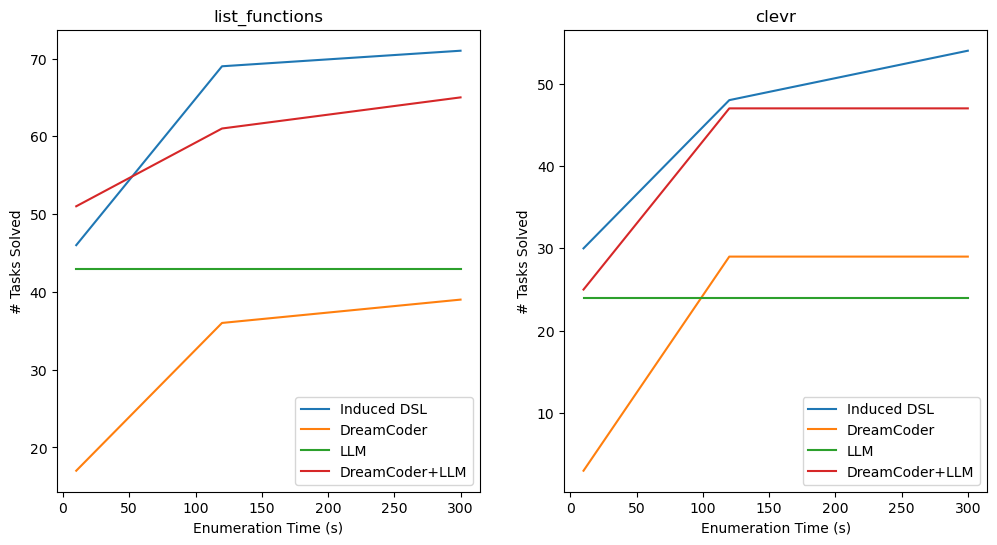

In [108]:
fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
axes = [axes] if len(domains) == 1 else axes
n_iters = 2

# Get # tasks solved by # samples.
# We want dfl_enum=120_nsamples=64 all
# dreamcoder_enum=120 all
# dfl_enum=120_nsamples=64 python first iteration

n = 64
res = {"Induced DSL": [], "DreamCoder": [], "LLM": [], "DreamCoder+LLM": []}
i = n_iters - 1     # Only want final iteration.
for domain, domain_res in exp_solved.items():

    # Get n tasks solved by our method.
    dfl_n_tasks_solved = {}
    llm_tasks_solved = []
    for enum in enum_times:
        if not domain_res[f"dfl_enum={enum}_nsamples={n}"]:
            continue
        tasks_solved = domain_res[f"dfl_enum={enum}_nsamples={n}"][0]
        iter_solved = set()
        for method, method_tasks_solved in tasks_solved.items():
            iter_solved.update(set(method_tasks_solved[i]))

        dfl_n_tasks_solved[enum] = len(iter_solved)
        llm_tasks_solved = tasks_solved[PYTHON][0]  # Shouldn't change across enum times.

    res["Induced DSL"].append(dfl_n_tasks_solved)

    # Get tasks solved by DreamCoder.
    dc_tasks_solved = {}
    for enum in enum_times:
        if not domain_res[f"dreamcoder_enum={enum}"]:
            continue
        tasks_solved = domain_res[f"dreamcoder_enum={enum}"][0]
        enum_tasks_solved = set()
        for method, method_tasks_solved in tasks_solved.items():
            enum_tasks_solved.update(set(method_tasks_solved[i]))
        dc_tasks_solved[enum] = enum_tasks_solved

    res["DreamCoder"].append({enum: len(dc_tasks_solved[enum]) for enum in dc_tasks_solved})

    # Get tasks solved by LLM.
    res["LLM"].append({enum: len(llm_tasks_solved) for enum in enum_times})

    # Get union of tasks.
    res["DreamCoder+LLM"].append(
        {enum: len(set(t) | set(llm_tasks_solved)) for enum, t in dc_tasks_solved.items()})

for i, (domain, ax) in enumerate(zip(domains, axes)):
    # {'Induced DSL': [{10: 46, 120: 69}], 'DreamCoder': [{10: 36, 120: 36}], 'LLM': [{10: 43, 120: 43}], 'DreamCoder+LLM': [{10: 61, 120: 61}]}

    dfl = res["Induced DSL"][i]
    xs, ys = zip(*dfl.items())

    ax.plot(xs, ys, label="Induced DSL")

    dc = res["DreamCoder"][i]
    xs, ys = zip(*dc.items())
    ax.plot(xs, make_nondecreasing(ys), label="DreamCoder")

    llm = res["LLM"][i]
    xs, ys = zip(*llm.items())
    ax.plot(xs, ys, label="LLM")

    dc_llm = res["DreamCoder+LLM"][i]
    xs, ys = zip(*dc_llm.items())
    ax.plot(xs, make_nondecreasing(ys), label="DreamCoder+LLM")

    ax.set_title(domain)
    ax.set_xlabel("Enumeration Time (s)")
    ax.set_ylabel("# Tasks Solved")
    ax.legend()
print(res)

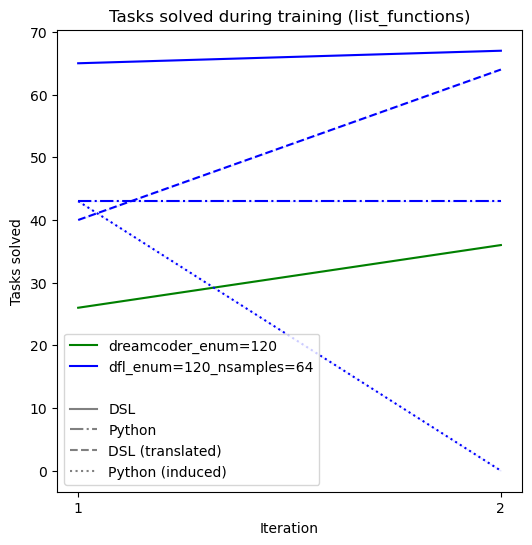

In [35]:
fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
axes = [axes] if len(domains) == 1 else axes

for domain, ax in zip(domains, axes):
    try:
        plot(exp_results[domain], domain, ax=ax)
    except:
        pass

In [ ]:
fig, (ax0, ax1, ax3) = plt.subplots(1, 3, figsize=(18, 6))



## Analyzing effect of removing redundant primitives

In [17]:
domains = ["list_functions"]
models = [
    "dfl_search_compress_enum=120_n=64",
    "dfl_search_collapse_compress_enum=120_n=64"
]

exp_name = "compression"
exp_results, exp_solved = {}, {}
for domain in domains:
    exp_results[domain], exp_solved[domain] = load_exp_results(exp_name, models, domain=domain, seeds=(0,))

exp_solved["list_functions"].keys()

dict_keys(['dfl_search_compress_enum=120_n=64', 'dfl_search_collapse_compress_enum=120_n=64'])

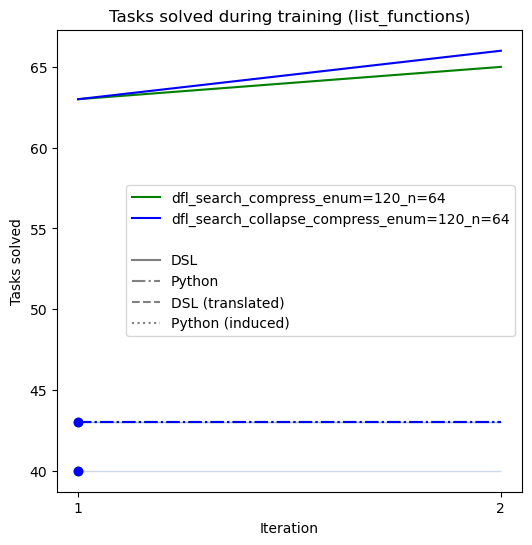

In [18]:
fig, axes = plt.subplots(1, len(domains), figsize=(6*len(domains), 6))
axes = [axes] if len(domains) == 1 else axes

for domain, ax in zip(domains, axes):
    plot(exp_results[domain], domain, ax=ax)